Hello Haoyuan!

My name is Dmitry.  I'm glad to review your work today.
I will mark your mistakes and give you some hints how it is possible to fix them. We are getting ready for real job, where your team leader/senior colleague will do exactly the same. Don't worry and study with pleasure! 

Below you will find my comments - **please do not move, modify or delete them**.

You can find my comments in green, yellow or red boxes like this:

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Success. Everything is done succesfully.
</div>

<div class="alert alert-block alert-warning">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Remarks. Some recommendations.
</div>

<div class="alert alert-block alert-danger">

<b>Reviewer's comment</b> <a class="tocSkip"></a>

Needs fixing. The block requires some corrections. Work can't be accepted with the red comments.
</div>

You can answer me by using this:

<div class="alert alert-block alert-info">
<b>Student answer.</b> <a class="tocSkip"></a>

Text here.
</div>

In [1]:
!pip install plotly_express

# Project objectives

* Preprocess the data

* Analyze the data

* Make suggestions for the game sales next year

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px
import requests
from scipy import stats

In [3]:
df = pd.read_csv("/datasets/games.csv")
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
df.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Pro tip: it is useful to check for duplicates also.
</div>

# Data Preprocessing

## Data Preprocessing Stragedy

The dataset contains 16715 entries and 11 columns.

* Replace the column names (make them lowercase).

* Data type:
    * DateTime: `year_release`
    * String: `name`, `platform`, `Genre` `Rating`
    * Float: `NA_sales`, `EU_sales`, `JP_sales`, `Other_sales`, `Critic_Score`, `User_Score`

* Missing values: `name`, `year_release`, `Genre`, `Critic_Score`, `User_Score` and `Rating`

### Replace the column name

In [6]:
df.rename(columns=lambda x: x.lower(), inplace=True)

### Convert data type and fill missing values

I'll address the missing values and convert data type together, because these two processes interact with each other.

#### `year_of_release`

##### Missing values

Before converting the datatype, I have to fill the missing values in advance.

In [7]:
df[df['year_of_release'].isna()]['name'].nunique()

232

The column `year_of_release` has 232 missing values. I could refill them with a certain value, but I found it's easy to find the released year on WiKipedia. Therefore I wrote a small crawler code and fetch the released year records.

In [8]:
url = "https://www.wikidata.org/w/api.php" 
query = "Slot Machine"
params = {
    'action': "wbsearchentities",
    'language': 'en',
    'format': 'json',
    'search': query
}
response = requests.get(url, params=params)
data = response.json()['search'][3]['description']
print(data)

1979 video game


In [9]:
# Web crawler for released year
"""
There are 3 kinds of outputs:
1. Perfect output (most of the outputs): "2003 American football video game" or "2001 video game". I can easily extract the released year from them even no need to use RE method.
The first element after splitting is the result.
2. Multiple responding results, I need to iterate all results until find the right one.
3. None or wrong output: coundn't find any information from the Wikipedia
"""
def process_item(item):
    url = "https://www.wikidata.org/w/api.php" 
    params = {
        'action': "wbsearchentities",
        'language': 'en',
        'format': 'json',
        'search': item
    }

    response = session.get(url, params=params)
    response_length = len(response.json()['search'])
    #print(response_length)
    if response_length == 0:
        not_found_list.append(item)
        #print(f"{item}: not found key word")
    else:
        for i in range(response_length):
            try:
                data = response.json()['search'][i]['description']
                #print(f"{item} = data: {data}")
                year = float(data.split()[0])
                df.loc[df['name']==item, 'year_of_release'] = year
                #print(year)
                break
            except:
                # not found in Wiki
                if i == response_length - 1:
                    #print(f"{item}: not found game")
                    not_found_list.append(item)
    

session = requests.Session()

missing_name_list = df[df['year_of_release'].isna()]['name'].unique()
#missing_name_list = ["Jet X20"]
not_found_list = []
for missing_name in missing_name_list:
    process_item(missing_name)

session.close()

There might be some wrong values when I drew from the web crawler. For example:

In [10]:
df[(df['year_of_release'] < 1980) | (df['year_of_release'] > 2016) ]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
609,Space Invaders,2600,1978.0,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
1506,Adventure,2600,1979.0,Adventure,1.21,0.08,0.00,0.01,NaN,NaN,NaN
1585,Combat,2600,1977.0,Action,1.17,0.07,0.00,0.01,NaN,NaN,NaN
1868,GRID,PS3,2019.0,Racing,0.31,0.56,0.03,0.20,87.0,8.1,E
2106,Air-Sea Battle,2600,1977.0,Shooter,0.91,0.06,0.00,0.01,NaN,NaN,NaN
2396,GRID,X360,2019.0,Racing,0.33,0.44,0.01,0.09,87.0,7.9,E
4264,Space Invaders,SNES,1978.0,Shooter,0.00,0.00,0.46,0.00,NaN,NaN,NaN
4437,Super Breakout,2600,1978.0,Puzzle,0.41,0.03,0.00,0.00,NaN,NaN,NaN
5041,Hangman,2600,2017.0,Puzzle,0.35,0.02,0.00,0.00,NaN,NaN,NaN
5800,Slot Machine,2600,1979.0,Action,0.29,0.02,0.00,0.00,NaN,NaN,NaN


The `year_of_lease` of game "Tornado" is 1917 and "GRID" is 2019. Obviously these number were under the coverage of my search pattern but were wrong. I'll replace them with `nan` and process it in the next step.

In [11]:
df.loc[(df['year_of_release'] < 1950) | (df['year_of_release'] > 2016), 'year_of_release'] = np.nan

In [12]:
df['year_of_release'].isna().sum()

71

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Wow! Very cool approach.
    
But it is really overkill =) We can just drop 232/16715 < 1,4% of missing values.
</div>

After searching in WikiPedia, we have 71 missing values of released year left. I'd like to fill them with random year in the range.

In [13]:
df['year_of_release'].fillna(float(np.random.randint(1980, 2016)), inplace=True)

<div class="alert alert-block alert-warning">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

It's not a good practice to fill NaNs with random values.
</div>

##### Convert the data type to DateTime

In [14]:
df['year_of_release'] = pd.to_datetime(df['year_of_release'].astype(int).astype(str)).dt.year

In [15]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


#### `name`

##### Missing values

In [16]:
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


There are two missing values on the `name` column, as well as on two kinds of scores and `rating` columns. I'll drop them.

In [17]:
df = df.dropna(subset=['name'])

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Well done!
</div>

#### `critic_score`, `user_score`

##### Replace 'tbd'

I found there is another missing value in `user_score`, "tbd", as an implicit missing value. I'll replace it with 'nan'

In [18]:
len(df[df['user_score'] == 'tbd'])

2424

In [19]:
df['user_score'] = df['user_score'].replace('tbd', np.nan)

In [20]:
df['user_score'] = df['user_score'].apply(lambda x: float(x) if x is not None else np.nan)

##### Missing values

There are many missing values in these two columns. 

* `critic_score`: 8578 (51.32%) missing values
* `user_score`: 9125 (54.6%) missing values

Let me check out whether they are missing at the same time.

In [21]:
df.loc[(df['critic_score'].isna()) & (df['user_score'].isna())]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Most of `user_score` missing values are missing in `critic_score` too.

**Fill missing values strategy:**

|number of missing values|`critic_score`|`user_score`|
| --                     | -- |            --        |
|8003                    | missing    |   missing    |
| 1122                   | have values|   missing    |
|575                     | missing    | have values  |

1. Check coefficient between `critic_score` and `user_score`, if they have positive correlation, I can use one to predict the other.

2. For both scores are missing, I'll check the coefficient between scores and sales, if they have positive correlation, I can use sales to predict scores.

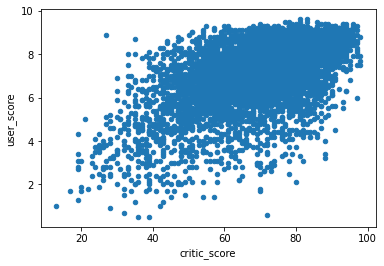

0.06031311046276153 2.945443122296556 0.5808778320767237 0.0 0.0010090961671206803


In [22]:
sub_table = df.dropna(subset=['critic_score', 'user_score'])
sub_table.plot.scatter(x='critic_score', y='user_score')
plt.show()
slope, intercept, r_value, p_value, std_err = stats.linregress(sub_table['critic_score'], sub_table['user_score'])
print(slope, intercept, r_value, p_value, std_err)

We can find that there is positive correlation between `critic_score` and `user_score`, 

* Slope: 0.06
* Intercept: 2.945
* the Pearson coefficience is 0.58
* the p-value is 0 < 0.05.
* std: 0.001

I'll complement the missing values in one column based on the given values in the other column. 

* Complement 

In [23]:
missing_in_critic_score_df = df[(df['critic_score'].isna()) & ~(df['user_score'].isna())]
missing_in_user_score_df = df[~(df['critic_score'].isna()) & (df['user_score'].isna())]

In [24]:
def complement_missing_values(df, fillered_df, x, y):
    """
    This function will caculate the linear relationship between two columns, and predict the missing values in one column
    based on given values in the other column
    1. Get the slope and intercept from linear formula
    2. Get the residuals and its std
    3. fill missing values in y
    """
    sub_table = df.dropna(subset=['critic_score', 'user_score'])
    sub_table.loc[:, 'user_score'] = sub_table['user_score'].apply(lambda x: float(x))
    fillered_df.loc[:, x] = fillered_df[x].astype('float')
    # 1. Get the slope and intercept from linear formula
    slope, intercept, r_value, p_value, std_err = stats.linregress(sub_table[x], sub_table[y])
    # 2. Get the residuals and its std
    score_residuals = sub_table[y] - (slope * sub_table[x] + intercept)
    std_dev = np.std(score_residuals)
    # 3. fill missing values in y
    fillered_df.loc[:, y] = round(slope * fillered_df[x] + intercept + np.random.normal(scale=std_dev), 1)
    return fillered_df

complemented_user_score = complement_missing_values(df, missing_in_user_score_df, x='critic_score', y='user_score')
complemented_critic_score = complement_missing_values(df, missing_in_critic_score_df, x='user_score', y='critic_score')
#complemented_critic_score

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [25]:
complemented_critic_score.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
255,Call of Duty: Advanced Warfare,PS3,2014,Shooter,1.56,1.93,0.19,0.68,53.9,4.8,M
263,Call of Duty: Advanced Warfare,X360,2014,Shooter,2.77,1.11,0.00,0.40,54.5,4.9,M
264,FIFA 15,PS3,2014,Sports,0.58,3.02,0.04,0.64,52.2,4.5,E
291,World Soccer Winning Eleven 9,PS2,2005,Sports,0.12,2.26,0.90,0.77,72.9,8.2,E
359,Just Dance 2014,Wii,2013,Misc,1.88,1.39,0.00,0.31,61.7,6.2,E10+


In [26]:
# Complement
def complement_missing_values(df, complemented_df, column):
    for index in complemented_df.index:
        df.loc[index, column] = complemented_df.loc[index, column]

complement_missing_values(df, complemented_critic_score, 'critic_score')
complement_missing_values(df, complemented_user_score, 'user_score')

Not let's address the missing values in both `critic_score` and `user_score` columns.

First I will create a new column to average the `critic_score` and `user_score`.

In [27]:
def avg_score(row):
    try:
        return (row['critic_score'] + row['user_score'] * 10) / 2
    except:
        return np.nan

df['avg_score'] = df.apply(avg_score, axis=1)
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,avg_score
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,78.0
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,82.5
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,80.0
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,NaN


Then I will find the relationship between sales in four regions and `avg_score`

In [28]:
df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].corrwith(df['avg_score'])

na_sales       0.161240
eu_sales       0.133187
jp_sales       0.141334
other_sales    0.122476
dtype: float64

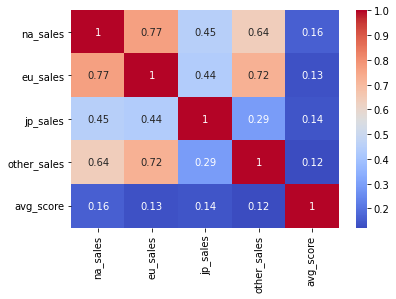

In [29]:
correlation_matrix = df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'avg_score']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

There are less relationship between `avg_score` and sales in four regions, I don't think it's a good idea to predict the `avg_score` using sales values.

In [30]:
missing_score_df = df.loc[(df['critic_score'].isna()) & (df['user_score'].isna())]
scored_df = df.loc[~((df['critic_score'].isna()) & (df['user_score'].isna()))]
print(missing_score_df.shape, scored_df.shape)

(8003, 12) (8710, 12)


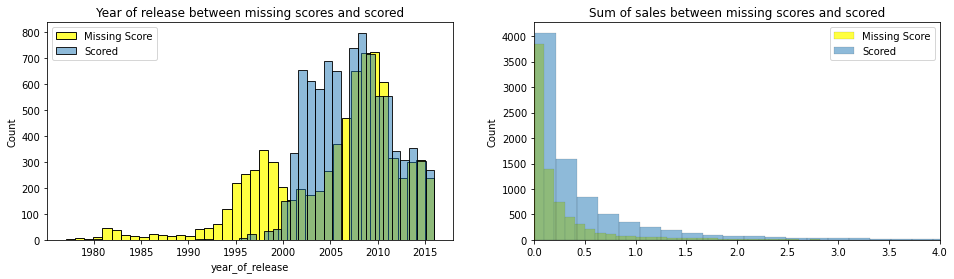

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
# Distribution of released year
sns.histplot(missing_score_df['year_of_release'], bins=40, label='Missing Score', color='yellow', kde=False, ax=axes[0])
sns.histplot(scored_df['year_of_release'], bins=40, label='Scored', alpha=0.5, kde=False, ax=axes[0])

# Distribution of sales
sns.histplot(missing_score_df['na_sales']+missing_score_df['eu_sales']+missing_score_df['jp_sales']+missing_score_df['other_sales'],
             bins=400, label='Missing Score', color='yellow', kde=False, ax=axes[1])
sns.histplot(scored_df['na_sales']+scored_df['eu_sales']+scored_df['jp_sales']+scored_df['other_sales'],
             bins=400, label='Scored', alpha=0.5, kde=False, ax=axes[1])

axes[0].set_title('Year of release between missing scores and scored')
axes[1].set_title('Sum of sales between missing scores and scored')
axes[1].set_xlim(0, 4)
axes[0].legend()
axes[1].legend()


plt.show()

I compared the tables with and without scores. We can find that most of games with scores are after 2000, whereas most of games before 2000 don't have scores. Furthermore, around 2000 was the time when the Internet became popular in the world. 

Therefore one of main reasons why there are so many missing scores is many games were released before 2000, and it don't have enough channels to collect user and critic scores.

I thought that maybe some games are not popular enough so no players want to score them. So I tried to compare the sum of sales of games. But I found the sales of 80% of games with and without scores are less than 0.5, It's hard to tell the difference.

I'll leave these missing values right now. If they affact subsequent analysis, I'll address it then.

<div class="alert alert-block alert-warning">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

You did a great job filling the gaps. But such a significant proportion of gaps can hardly be correctly restored from the available values.
</div>

#### `genre`

In [32]:
df['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

The missing values of `genre` has been deleted during clearning the `name` column.

Let's have a look at the proportion of each class.

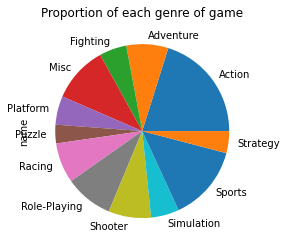

In [33]:
df.groupby('genre').count()['name'].plot(kind='pie', title='Proportion of each genre of game')
plt.show()

Looking at all the yearly spans in the dataframe, there are 12 kinds of genre, and they divide the share evenly except 'Action' and 'Sports' have slightly higher proportion.

In [34]:
df.groupby(['year_of_release', 'genre']).count()['name']

year_of_release  genre       
1977             Action           1
                 Shooter          1
1978             Action           1
                 Puzzle           1
                 Shooter          4
                                 ..
2016             Role-Playing    54
                 Shooter         47
                 Simulation      18
                 Sports          51
                 Strategy        14
Name: name, Length: 397, dtype: int64

In [35]:
#fig = px.histogram(df.groupby(['year_of_release', 'genre']).count()['name'], x='year_of_release', nbins=30, color='genre', barmode='overlay')

#### `na_sales`, `eu_sales`, `jp_sales`, `other_sales`

for calcualting with other features, I will add a column to record the sum of these four regions

In [36]:
df['sum_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,avg_score,sum_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,78.0,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,82.5,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,80.0,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,NaN,31.38


#### `rating`

In [37]:
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

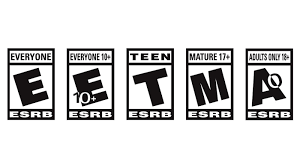

* EC: Early Childhood
* E: Everyone (E)
* E10+: Everyone 10+ (E10+)
* T: Teen (T)
* M: Mature 17+
* AO: Adults Only 18+ (AO)
* RP: Rating Pending (RP)

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Thanks for the additional information =)
</div>

##### Missing values

In [38]:
df['rating'].isna().sum()

6764

In [39]:
missing_rating_df = df[df['rating'].isna()]
rating_df = df[~df['rating'].isna()]

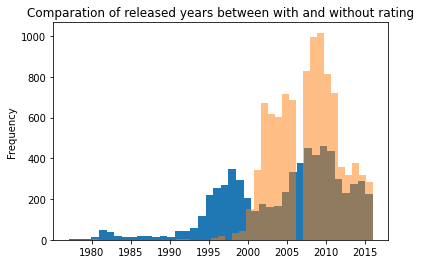

In [40]:
ax1 = missing_rating_df['year_of_release'].plot(kind='hist', bins=40, title='Comparation of released years between with and without rating')
ax2 = rating_df['year_of_release'].plot(kind='hist', alpha=0.5, bins=40)

Similar to `critic_score` and `user_score`, the ESRB rating was introduced around 1995 - 2000. The missing values of `rating` highly conincide with missing values in score columns.

I will compare sales in four regions with and without rating.

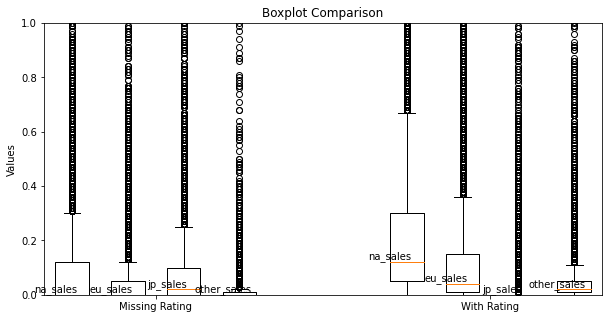

In [41]:
fig, ax = plt.subplots(figsize=(10, 5))
box1 = ax.boxplot(missing_rating_df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']], positions=[1, 2, 3, 4], widths=0.6)
box2 = ax.boxplot(rating_df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']], positions=[7, 8, 9, 10], widths=0.6)

ax.set_xticks([2.5, 8.5])
ax.set_xticklabels(['Missing Rating', 'With Rating'])
ax.set_ylim(0, 1)
plt.title('Boxplot Comparison')
plt.ylabel('Values')

# add label
labels = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
for i, box in enumerate([box1, box2]):
    for j, line in enumerate(box['medians']):
        x = box['medians'][j].get_xdata()[0]
        y = box['medians'][j].get_ydata()[0]
        ax.text(x, y, labels[j], ha='center', va='bottom')

plt.show()


There are interesting facts

1. In the missing rating group, the distribution of `jp_sale` is consistent with `na_sales`, and more than `eu_sales` and `other_sales`.

2. In the group with rating, the `na_sale`, `eu_sale` and `other_sales` have significantly increase, while the `jp_sales` almost drops to 0. 

At last, I'll fill missing values in `genre` column to 'Unknown'

In [42]:
df['rating'].fillna('UNKNOWN', inplace=True)

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Correct.
</div>

## Analyze the data

### `games` vs `year`

How many games are released each year?

In [43]:
df.groupby('year_of_release').count()['name']

year_of_release
1977       2
1978       6
1979       2
1980      15
1981      46
1982      37
1983      17
1984      15
1985      14
1986      21
1987      18
1988      15
1989      19
1990      16
1991      44
1992      48
1993      60
1994     120
1995     220
1996     264
1997     291
1998     379
1999     341
2000     355
2001     488
2002     849
2003     783
2004     769
2005     952
2006    1019
2007    1208
2008    1445
2009    1433
2010    1275
2011    1158
2012     655
2013     547
2014     652
2015     609
2016     506
Name: name, dtype: int64

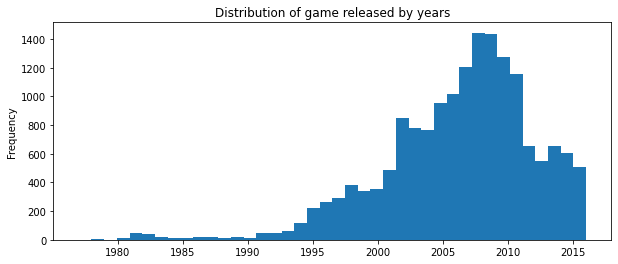

In [44]:
df['year_of_release'].plot(kind='hist', bins=40, figsize=(10,4), title='Distribution of game released by years')
plt.show()

We can conclude that there are four periods of games be released. 

1. 1978 - 1990. The dawn of games. There are 15 - 20 games every year.
2. 1990 - 2001. The number of yearly released games is increasing from 44 in 1991 to 488 in 2001.
3. 2002 - 2011. The Peak of games. The number of yearly released games jumps up to 700, and in the year of 2008 and 2009, the number becomes to peak which is more than 1400.
4. 2012 - 2016. There is an obvious drop down. The yearly released games decreases to 500 - 600. I think the reason is the mobile games are more and more popular.

### Sales between platforms

#### Sales by platforms

Look at how sales varied from platform to platform. 

In [45]:
df.groupby('platform')['sum_sales'].sum().sort_values(ascending=False)

platform
PS2     1255.77
X360     971.42
PS3      939.65
Wii      907.51
DS       806.12
PS       730.86
GBA      317.85
PS4      314.14
PSP      294.05
PC       259.52
3DS      259.00
XB       257.74
GB       255.46
NES      251.05
N64      218.68
SNES     200.04
GC       198.93
XOne     159.32
2600      96.98
WiiU      82.19
PSV       54.07
SAT       33.59
GEN       28.35
DC        15.95
SCD        1.86
NG         1.44
WS         1.42
TG16       0.16
3DO        0.10
GG         0.04
PCFX       0.03
Name: sum_sales, dtype: float64

The top popular platforms are 'PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', but some new generation platforms such as 'PS4', 'WiiU' are not listed in due to their total sales don't accumulate so many years.

#### Top 6 platforms

I pick the top 6 platforms with the greatest total sales and build a distribution based on data for each year. 

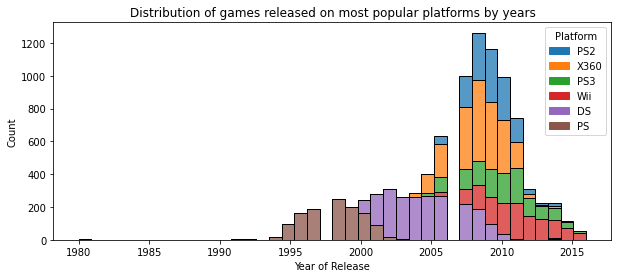

In [46]:
popular_platforms = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']
popular_platforms_df = df[df['platform'].isin(popular_platforms)]

plt.figure(figsize=(10, 4))
sns.histplot(data=popular_platforms_df, x='year_of_release', hue='platform', multiple='stack', bins=40)

# 创建自定义图例
legend_labels = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']
legend_elements = [plt.Rectangle((0, 0), 1, 1, color=sns.color_palette()[i]) for i in range(len(legend_labels))]
plt.legend(legend_elements, legend_labels, title='Platform')

plt.title('Distribution of games released on most popular platforms by years')
plt.xlabel('Year of Release')
plt.ylabel('Count')
plt.show()

We can see that nearly all most popular platforms are gone at the year of 2016 except 'Wii'. Typically, a platfrom appears and an old one fade off takes about 10 years.

#### Determine the  period

To analyze and predict the sales of 2017, we only care about the platforms which still release games in recent 5 years.

In [47]:
valid_df = df[df['year_of_release'] > 2011]

<div class="alert alert-block alert-warning">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

It is uncommon to use data for more than 2-3 years when forecasting next year's sales, even in case of traditional businesses. And in the dynamic computer games industry, taking longer time intervals should be avoided as it will definitely lead to tracking some obsolete trends. But you shouldn't take too short a period either.
</div>

##### The progress of platforms


In [48]:
valid_df.groupby("platform")['sum_sales'].sum().sort_values(ascending=False)

platform
PS4     314.14
PS3     291.63
X360    239.55
3DS     194.92
XOne    159.32
WiiU     82.19
PC       63.96
PSV      48.68
Wii      36.65
DS       13.57
PSP      12.47
PS2       1.49
2600      1.17
GBA       0.82
PS        0.13
XB        0.03
Name: sum_sales, dtype: float64

In [49]:
pd.pivot_table(valid_df, index='year_of_release', columns='platform', values='sum_sales', aggfunc='sum', fill_value=0).reset_index()

platform,year_of_release,2600,3DS,DS,GBA,PC,PS,PS2,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XB,XOne
0,2012,0.15,51.36,11.01,0.00,23.23,0.00,0.00,107.36,0.00,7.69,16.02,21.71,17.56,99.81,0.00,0.00
1,2013,0.00,56.57,1.54,0.00,12.57,0.00,0.00,114.38,25.99,3.14,10.26,8.59,21.65,89.70,0.00,18.96
2,2014,1.02,44.07,1.02,0.82,14.29,0.13,1.49,49.15,100.00,1.52,11.90,5.03,22.03,36.24,0.03,54.07
3,2015,0.00,27.78,0.00,0.00,8.53,0.00,0.00,16.89,118.90,0.12,6.25,1.14,16.35,11.97,0.00,60.14
4,2016,0.00,15.14,0.00,0.00,5.34,0.00,0.00,3.85,69.25,0.00,4.25,0.18,4.60,1.83,0.00,26.15


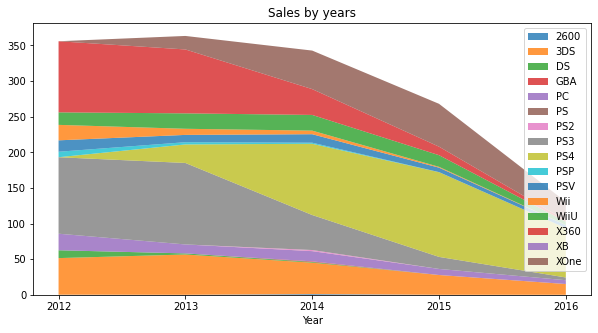

In [50]:
sales_by_platform = pd.pivot_table(valid_df, index='year_of_release', columns='platform', values='sum_sales', aggfunc='sum', fill_value=0).reset_index()
column_dict = sales_by_platform.iloc[:, 1:].to_dict('series')
fig, ax = plt.subplots(figsize=(10, 5))
ax.stackplot(sales_by_platform['year_of_release'], column_dict.values(), labels=column_dict.keys(), alpha=0.8)
ax.legend(loc='upper right')
ax.set_title("Sales by years")
ax.set_xticks(sales_by_platform['year_of_release'])
ax.set_xlabel("Year")
plt.show()

We can conclude that the platforms of 'PS3', 'PS4' and 'X360' are leading sales in 5 years.

* Growing platforms: 'PS4'
* Shrinking platforms: '3DS', 'PS3', 'X360', 'XOne'

According to the stackplot, I'd like to choose '3DS', 'PS4', 'XOne' as the most important platforms. I'll choose 'PC', 'WiiU' and 'PSV' too, although the their proportions are very low, they still have stable sales throught out these years. 

For the platforms of 'PS3', '2600' and others, their proportions shrink very much even gone. Therefore I won't consider them.

In [51]:
valid_list = [ '3DS', 'PS4', 'XOne','PC', 'WiiU', 'PSV']
valid_df = df[df['platform'].isin(valid_list)]
valid_df.shape

(2710, 13)

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Nice graph.
</div>

#### Global sales by platform


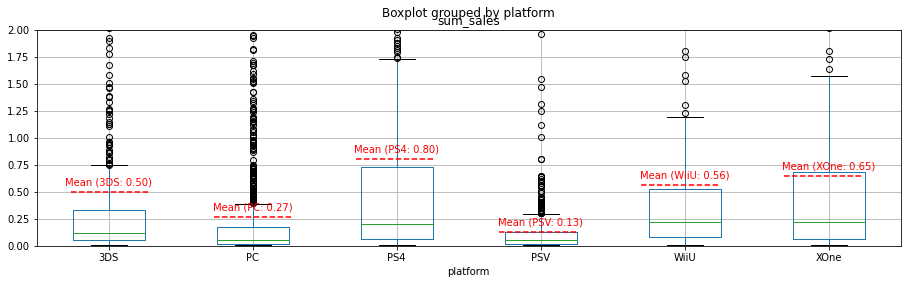

In [52]:
ax = valid_df.boxplot(column='sum_sales', by='platform', figsize=(15, 4))
ax.set_ylim(0, 2)

# calculate means of each platform
platform_means = valid_df.groupby('platform')['sum_sales'].mean()
# get position of each bpx
positions = range(0, len(platform_means))

# add hline for each box
for platform, mean, pos in zip(platform_means.index, platform_means.values, positions):
    plt.axhline(mean, color='red', linestyle='--', xmin=0.04+pos*0.165, xmax=0.13+pos*0.165)
    ax.text(pos + 1, mean+0.05, f'Mean ({platform}: {mean:.2f})', ha='center', va='bottom', color='red')


plt.show()

All platforms have many outliers, I truncate them and limit the y-axis (sales) to 2.00. 

From the boxplot we can see the platform 'PS4' has the widest body. For the means of platforms, "PS4" has the highest mean values. The platforms of '3DS', 'WiiU' and 'XOne' have similar mean values which lower than 'PS4'.

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Wow! Very good boxplots.
</div>

#### 'reviews' vs 'platforms'

I'll check how user and professional reviews affect sales for 'PS4' 

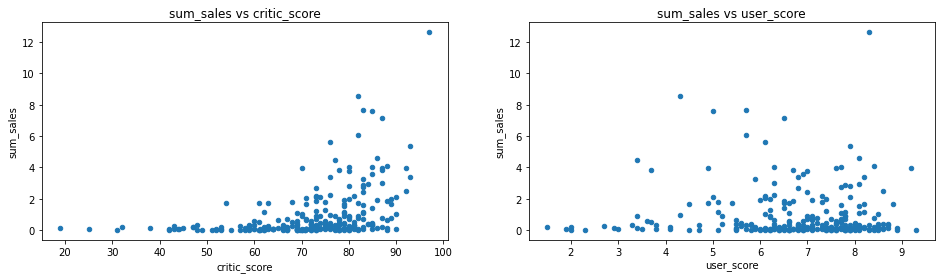

In [53]:
ps4_df = valid_df[valid_df['platform']=='PS4']
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

ps4_df.plot.scatter(x='critic_score', y='sum_sales', ax=axes[0])
ps4_df.plot.scatter(x='user_score', y='sum_sales', ax=axes[1])

axes[0].set_title('sum_sales vs critic_score')
axes[1].set_title('sum_sales vs user_score')

plt.show()                  

In [54]:
print(f"The correlation between `sum_sales` and `critic_score` is {ps4_df['sum_sales'].corr(ps4_df['critic_score']):.3f},\n"
     f"The correlation between `sum_sales` and `user_score` is {ps4_df['sum_sales'].corr(ps4_df['user_score']):.3f}")

The correlation between `sum_sales` and `critic_score` is 0.409,
The correlation between `sum_sales` and `user_score` is -0.041


We can conclude from the scatter plots and the coorelation that 
1. `sum_sales` and `critic_score` have weak coorelationship.
2. `sum_sales` and `user_score` don't have coorelationship.

#### Compare the sales of the same games on other platforms.

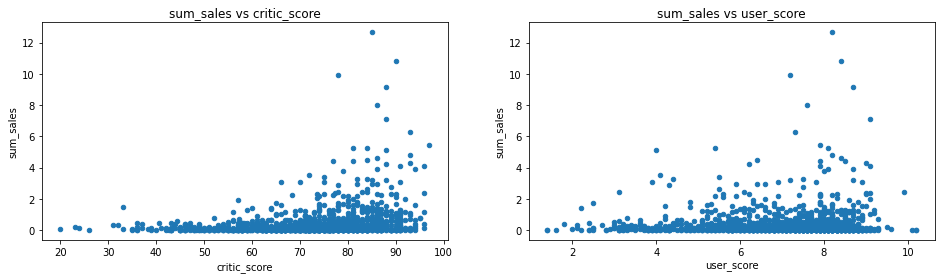

In [55]:
other_df = valid_df[~(valid_df['platform']=='PS4')]
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

other_df.plot.scatter(x='critic_score', y='sum_sales', ax=axes[0])
other_df.plot.scatter(x='user_score', y='sum_sales', ax=axes[1])

axes[0].set_title('sum_sales vs critic_score')
axes[1].set_title('sum_sales vs user_score')

plt.show()   

In [56]:
print(f"The correlation between `sum_sales` and `critic_score` is {other_df['sum_sales'].corr(other_df['critic_score']):.3f},\n"
     f"The correlation between `sum_sales` and `user_score` is {other_df['sum_sales'].corr(other_df['user_score']):.3f}")

The correlation between `sum_sales` and `critic_score` is 0.237,
The correlation between `sum_sales` and `user_score` is 0.043


Similar to 'PS4', reviews and sales of games on other platforms don't have strong correlations.
1. sum_sales and critic_score have weaker coorelationship than 'PS4'.
2. sum_sales and user_score don't have coorelationship.

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Good job.
</div>

#### Games by genre


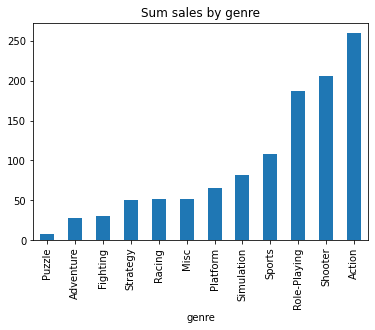

In [57]:
valid_df.groupby('genre')['sum_sales'].sum().sort_values().plot(kind='bar', title='Sum sales by genre')
plt.show()


The most profitable genres are "Action", "Shooter", and "Role-Playing", they are more competitive. On the other hand, the genres of 'Puzzle', 'Adventrue' and 'Strategy' are more leisure with less pressure during playing, they have worst sales.

## Create a user profile for each region


### Top five platforms for each region

In [58]:
top5_platform_na = valid_df.groupby('platform')['na_sales'].sum().sort_values(ascending=False).reset_index()[:5]
top5_platform_eu = valid_df.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).reset_index()[:5]
top5_platform_jp = valid_df.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).reset_index()[:5]

In [59]:
print(f"""
The top 5 platforms in NA are {top5_platform_na['platform'].tolist()}
The top 5 platforms in EU are {top5_platform_eu['platform'].tolist()}
The top 5 platforms in JP are {top5_platform_jp['platform'].tolist()}
""")


The top 5 platforms in NA are ['PS4', 'PC', 'XOne', '3DS', 'WiiU']
The top 5 platforms in EU are ['PC', 'PS4', '3DS', 'XOne', 'WiiU']
The top 5 platforms in JP are ['3DS', 'PSV', 'PS4', 'WiiU', 'XOne']



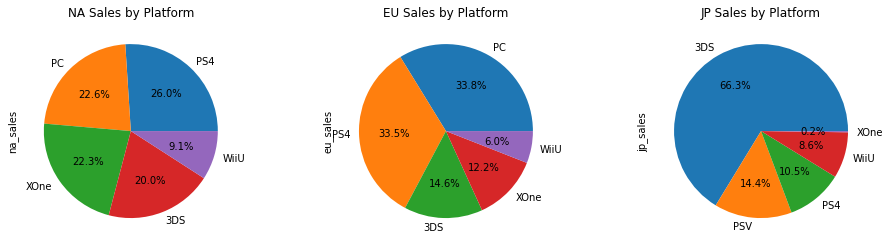

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
top5_platform_na.plot(kind='pie', y='na_sales', labels=top5_platform_na['platform'], autopct='%1.1f%%', legend=False, ax=axes[0])
top5_platform_eu.plot(kind='pie', y='eu_sales', labels=top5_platform_eu['platform'], autopct='%1.1f%%', legend=False, ax=axes[1])
top5_platform_jp.plot(kind='pie', y='jp_sales', labels=top5_platform_jp['platform'], autopct='%1.1f%%', legend=False, ax=axes[2])

axes[0].set_title('NA Sales by Platform')
axes[1].set_title('EU Sales by Platform')
axes[2].set_title('JP Sales by Platform')
plt.show()

According to the pie charts above:
* NA marketing: 'PS4' is the most popular platform with 26.0% proportion in sales. The platforms of 'PC', 'XOne' and '3DS' are similar, has a 20%-22% share each. The left 9.1% share is owned by "WiiU".
* EU marketing: "PC" and "PS4" are the most popular platforms with 33% share each. "3DS", "XOne" and "WiiU" share the left. Additionally, NA and EU have same top 5 platforms.
* JP marketing: "3DS" dominates the game marketing, it has 2/3 total sales. 'PSV', 'PS4' and 'WiiU' are less and less by one by. The smallest platform is 'XOne' which only take 0.2% share.

In general, the top 5 platforms in NA and EU marketing are same. But 'PC' and "PS4" in EU marketing are stronger. In the other hand, in JP marketing, customers like portable games more, so '3DS' and 'PSV' dominate the game marketing.

### Top five genres for each region

In [61]:
top5_genre_na = valid_df.groupby('genre')['na_sales'].sum().sort_values(ascending=False).reset_index()[:5]
top5_genre_eu = valid_df.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).reset_index()[:5]
top5_genre_jp = valid_df.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).reset_index()[:5]

In [62]:
print(f"""
The top 5 genre in NA are {top5_genre_na['genre'].tolist()}
The top 5 genre in EU are {top5_genre_eu['genre'].tolist()}
The top 5 genre in JP are {top5_genre_jp['genre'].tolist()}
""")


The top 5 genre in NA are ['Action', 'Shooter', 'Role-Playing', 'Sports', 'Simulation']
The top 5 genre in EU are ['Action', 'Shooter', 'Role-Playing', 'Sports', 'Simulation']
The top 5 genre in JP are ['Role-Playing', 'Action', 'Platform', 'Misc', 'Simulation']



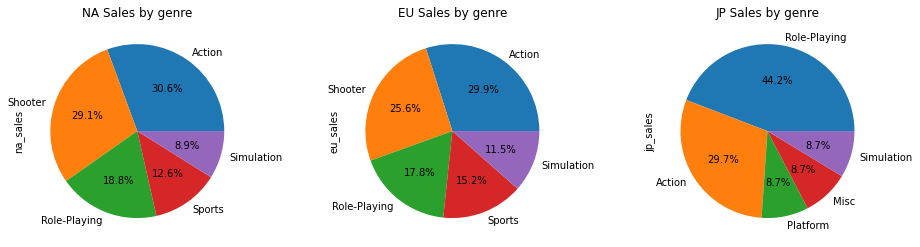

In [63]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
top5_genre_na.plot(kind='pie', y='na_sales', labels=top5_genre_na['genre'], autopct='%1.1f%%', legend=False, ax=axes[0])
top5_genre_eu.plot(kind='pie', y='eu_sales', labels=top5_genre_eu['genre'], autopct='%1.1f%%', legend=False, ax=axes[1])
top5_genre_jp.plot(kind='pie', y='jp_sales', labels=top5_genre_jp['genre'], autopct='%1.1f%%', legend=False, ax=axes[2])

axes[0].set_title('NA Sales by genre')
axes[1].set_title('EU Sales by genre')
axes[2].set_title('JP Sales by genre')
plt.show()

The top 5 genres in both NA and EU marketing are same even proportions, they are 'Action', 'Shooter', 'Role-Playing', 'Sports' and 'Simulation'. The sum of 'Action' and 'Shooter' are more than half, and the other 3 genres share the left marketing.

In JP marketing, 'Role-Playing' takes 44.2%, 'Action' takes 29.7%. The other 3 genres, 'Simulation', 'Misc', and 'Platform' take 8.7% each.

### Do ESRB ratings affect sales in individual regions?

In [64]:
top5_rating_na = valid_df.groupby('rating')['na_sales'].sum().sort_values(ascending=False).reset_index()[:5]
top5_rating_eu = valid_df.groupby('rating')['eu_sales'].sum().sort_values(ascending=False).reset_index()[:5]
top5_rating_jp = valid_df.groupby('rating')['jp_sales'].sum().sort_values(ascending=False).reset_index()[:5]
print(f"""
The top 5 rating in NA are {top5_rating_na['rating'].tolist()}
The top 5 rating in EU are {top5_rating_eu['rating'].tolist()}
The top 5 rating in JP are {top5_rating_jp['rating'].tolist()}
""")


The top 5 rating in NA are ['M', 'UNKNOWN', 'E', 'T', 'E10+']
The top 5 rating in EU are ['M', 'UNKNOWN', 'E', 'T', 'E10+']
The top 5 rating in JP are ['UNKNOWN', 'E', 'T', 'M', 'E10+']



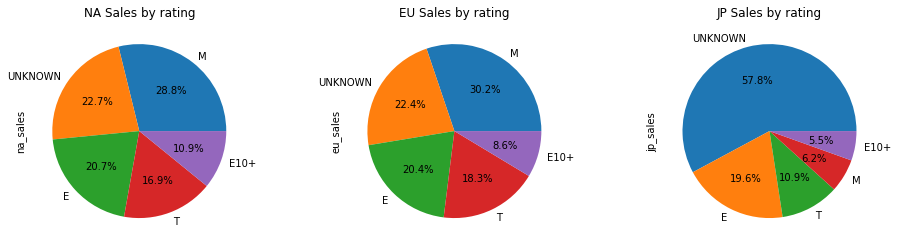

In [65]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
top5_rating_na.plot(kind='pie', y='na_sales', labels=top5_rating_na['rating'], autopct='%1.1f%%', legend=False, ax=axes[0])
top5_rating_eu.plot(kind='pie', y='eu_sales', labels=top5_rating_eu['rating'], autopct='%1.1f%%', legend=False, ax=axes[1])
top5_rating_jp.plot(kind='pie', y='jp_sales', labels=top5_rating_jp['rating'], autopct='%1.1f%%', legend=False, ax=axes[2])

axes[0].set_title('NA Sales by rating')
axes[1].set_title('EU Sales by rating')
axes[2].set_title('JP Sales by rating')
plt.show()

Similar to `genre` column, the NA and EU sales by rating are same. The top 5 ratings are 'M', 'UNKNOWN', 'E', 'T', and 'E10+'. 

In JP market, the sales with 'UNKNOWN' rating takes 57.8%, the 'E' rating taks 19.6%, and others are equal or less than 10% each. 

Sales of those without ratings are less likely affected in JP market.

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Very good and clear graphs! Thank you for comparison and intresting facts!
</div>

## Test the following hypotheses:

### Average user ratings of the Xbox One and PC platforms are the same.


* Null Hypothesis $H_0$: The average user ratings of Xbox One and PC platforms are the same.
* Alternative Hypothesis $H_1$: The average user ratings of Xbox One and PC platforms are different.
* $\alpha = 0.05%$: The reason I chose the significant level $\alpha = 0.05%$ is not only it has been widely used to prove the significant difference in test between two groups, but also it can make a balance between Type I and II errors.

In [66]:
user_score_XOne = valid_df[valid_df['platform'] == 'XOne']
user_score_PC = valid_df[valid_df['platform'] == 'PC']
alpha = 0.05
results = stats.ttest_ind(user_score_XOne['user_score'].dropna(), user_score_PC['user_score'].dropna(), equal_var=False)
print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")


p-value: 7.758336736189492e-06
We reject the null hypothesis


### Average user ratings for the Action and Sports genres are different.

* Null Hypothesis $𝐻0$: The average user ratings of Xbox One and PC platforms are the same.
* Alternative Hypothesis $𝐻1$: The average user ratings of Xbox One and PC platforms are different.
* $\alpha = 0.05$

In [69]:
user_score_Action = valid_df[valid_df['genre'] == 'Action']['user_score'].dropna()
user_score_Sports = valid_df[valid_df['genre'] == 'Sports']['user_score'].dropna()
alpha = 0.05
results = stats.ttest_ind(user_score_Action, user_score_Sports, equal_var=False)
print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: 1.430331786680468e-08
We reject the null hypothesis


<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Correct.
</div>

## Conclusion

During preprocessing, the biggest problem is there are many missing values in `name` and two scores. I extracted some missing names from WikiPedia by a web crawler script. Then I found `user_score` and `critic_score` had positive correlation, so I predicted partial missing values for each other. But the missing values still happen in `user_score`, `critic_score` and `rating` columns at the same time. I couldn't fill them rationally, therefore I left them with 'NA' or 'Unknown'.

Then I tried to analyze the relationship between columns.

* **Years of release:** There are three stages throughout the numbers of video games: beginning, peak stage and slump stage. The same situation happened in game platforms, the life period of them is about 10 years. To analyze and predict sales in 2017, I only need to care about the top 6 platforms which still release games in recent 5 years.

* **Platforms:** Among these 6 platforms, The 'PS4' has the greatest sale profits. For the means of platforms, "PS4" has the highest mean values. The platforms of '3DS', 'WiiU' and 'XOne' have similar mean values but less sales than 'PS4'.

* **Reviews:** Perfessional reviews make weak positive effect to sales, but user reviews don't affect sales.

* **Genres:** The most profitable genres are "Action", "Shooter", and "Role-Playing", they are more competitive. On the other hand, the genres of 'Puzzle', 'Adventrue' and 'Strategy' are more leisure with less pressure during playing, they have worst sales.

* **Regions:** Game sales in North America and Europe are homogeneous, they have same top 5 platforms, genres and ESRB rating. However, popular platforms, genres and rating are different in Japan market. Players like portable platforms and less competitive games.

At last I made two statistical inferences and proved the average user ratings of two platforms and two genres are different.

**Suggestions for games sales in 2017:**

In order to pursue potential profit, our stores should use different sale strategy in seperate marketing regions. 

In NA and EU regions, we need to give more marketing resources to "PC", "PS4", "3DS" and "XOne" platforms as well as 'Action', 'Shooter', 'Role-Playing', 'Sports' and 'Simulation' games.

On the other hand, in JP market, we need to pay more attention on "3DS", 'PSV', 'PS4' and 'WiiU', as well as 'Role-Playing' and 'Action' games. Additionally, the ESRB rating doesn't make siginifant effect on JP market, we can sale games without ESRB rating.

We still need to invite more professional reviews, since the critic scores will be helpful for game sales.

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Great final conclusion!
</div>

<div class="alert alert-block alert-success">
<b>Overall reviewer's comment</b> <a class="tocSkip"></a>

Haoyuan, thank you for sending your project. You've done a really good job on it!
    
Especially impressed:

- cool additional approaches/analysis
    
- deep detailed conclusions
    
- good graphs
    
- high code level

- good project structure
    
    
Thank you for in-depth analysis and logical conclusions!
    
I'm glad to say that your project has been accepted. Keep up the good work, and good luck on the next sprint!
</div>